In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")

In [3]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info_80.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )
replay_info = replay_info.rename_axis(index={"animal": "Animal ID"})
replay_info.head()

start_time  \
Animal ID day epoch ripple_number                              
Cor       1   2     1              0 days 00:22:39.771534985   
                    2              0 days 00:23:00.114870107   
                    3              0 days 00:23:16.240204859   
                    4              0 days 00:23:21.014871945   
                    5              0 days 00:23:21.862205353   

                                                    end_time  duration  \
Animal ID day epoch ripple_number                                        
Cor       1   2     1              0 days 00:22:39.809534988  0.038000   
                    2              0 days 00:23:00.142870110  0.028000   
                    3              0 days 00:23:16.308871531  0.068667   
                    4              0 days 00:23:21.102871953  0.088000   
                    5              0 days 00:23:21.910205357  0.048000   

                                   Continuous_duration  Fragmented_duration  \
Animal ID day epoch ripple_number                                             
Cor       1   2     1                            0.000                  0.0   
                    2                            0.000                  0.0   
                    3                            0.000                  0.0   
                    4                            0.078                  0.0   
                    5                            0.000                  0.0   

                                   Fragmented-Continuous-Mix_duration  \
Animal ID day epoch ripple_number                                       
Cor       1   2     1                                           0.000   
                    2                                           0.000   
                    3                                           0.000   
                    4                                           0.004   
                    5                                           0.000   

                                   Hover_duration  \
Animal ID day epoch ripple_number                   
Cor       1   2     1                       0.000   
                    2                       0.026   
                    3                       0.030   
                    4                       0.000   
                    5                       0.000   

                                   Hover-Continuous-Mix_duration  Continuous  \
Animal ID day epoch ripple_number                                              
Cor       1   2     1                                      0.030       False   
                    2                                      0.000       False   
                    3                                      0.038       False   
                    4                                      0.000        True   
                    5                                      0.038       False   

                                   Fragmented  ...  left_well_position  \
Animal ID day epoch ripple_number              ...                       
Cor       1   2     1                   False  ...          301.995144   
                    2                   False  ...          301.995144   
                    3                   False  ...          301.995144   
                    4                   False  ...          301.995144   
                    5                   False  ...          301.995144   

                                   right_arm_start  right_well_position  \
Animal ID day epoch ripple_number                                         
Cor       1   2     1                    88.788252             183.8834   
                    2                    88.788252             183.8834   
                    3                    88.788252             183.8834   
                    4                    88.788252             183.8834   
                    5                    88.788252             183.8834   

                                   max

In [4]:
frag = replay_info.loc[
    (replay_info.loc[:, "Fragmented_duration"] > 0.100)
    & (replay_info.loc[:, "Fragmented_replay_speed"] / 100 > 30)
    & (replay_info.loc[:, "Fragmented"])
    & ~(replay_info.loc[:, "Hover"])
    & ~(replay_info.loc[:, "Hover-Continuous-Mix"])
    & ~(replay_info.loc[:, "Continuous"])
    & ~(replay_info.loc[:, "Fragmented-Continuous-Mix"])
]
frag.loc[
    :,
    ["Fragmented_duration", "Fragmented_spatial_coverage", "Fragmented_replay_speed",],
]

Fragmented_duration  \
Animal ID day epoch ripple_number                        
bon       7   6     54                           0.104   
                    120                          0.108   
fra       8   6     143                          0.108   
          9   6     95                           0.102   
          10  6     34                           0.108   

                                   Fragmented_spatial_coverage  \
Animal ID day epoch ripple_number                                
bon       7   6     54                              250.800244   
                    120                             258.133584   
fra       8   6     143                             270.981316   
          9   6     95                              261.767149   
          10  6     34                              264.134961   

                                   Fragmented_replay_speed  
Animal ID day epoch ripple_number                           
bon       7   6     54                        13651.162419  
                    120                       11319.157908  
fra       8   6     143                       16189.421709  
          9   6     95                         8884.541039  
          10  6     34                         9984.896314

In [5]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(n_workers=28, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:32845 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 28 Cores: 28 Memory: 1.62 TB


In [6]:
import copy

from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
)
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)
from src.figure3 import plot_clusterless_1D_results, plot_1D_projected_to_2D
from src.visualization import make_classifier_movie
import xarray as xr


def plot_ripple_figure_1D(
    epoch_key, ripple_numbers, is_save_figure=True, cmap="bone_r", make_movie=True,
):
    if isinstance(ripple_numbers, int):
        ripple_numbers = [ripple_numbers]
    data_type, dim = "clusterless", "1D"
    animal, day, epoch = epoch_key
    data = load_data(epoch_key)

    multiunit_times = [
        get_multiunit_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
    if multiunit_times[0] is None:
        multiunit_times = [
            get_multiunit_dataframe2(tetrode_key, ANIMALS)
            for tetrode_key in data["tetrode_info"].index
        ]

    # Fit
    is_training = data["position_info"].speed > 4
    position = data["position_info"].loc[:, "linear_position"]
    track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

    model_name = os.path.join(
        PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
    )
    classifier = ClusterlessClassifier.load_model(model_name)

    results = xr.open_dataset(
        os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02d}_{epoch:02d}.nc"),
        group=f"/{data_type}/{dim}/classifier/ripples/",
    )

    for ripple_number in ripple_numbers:
        print(ripple_number)
        plot_clusterless_1D_results(
            multiunit_times,
            data,
            results.sel(ripple_number=ripple_number).dropna("time", how="all"),
            classifier,
            epoch_key,
            ripple_number,
            cmap=cmap,
            is_save_figure=is_save_figure,
        )
        plt.suptitle(f"{animal}, {day}, {epoch}, {ripple_number}")
        if make_movie:
            make_classifier_movie(classifier, results, ripple_number, data, epoch_key)

('bon', 7, 6)


08-Oct-20 11:33:01 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
08-Oct-20 11:33:01 No DIO file found, using distance from well to segment trials
08-Oct-20 11:33:02 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
08-Oct-20 11:33:02 No DIO file found, inferring correct inbound/outbound from task rules
08-Oct-20 11:33:44 Finding ripple times...
08-Oct-20 11:36:42 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
08-Oct-20 11:36:42 No DIO file found, using distance from well to segment trials
08-Oct-20 11:36:44 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
08-Oct-20 11:36:44 No DIO file found, inferring correct inbound/outbound from task rules


54
120
('fra', 8, 6)


08-Oct-20 11:38:32 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO08.mat
08-Oct-20 11:38:32 No DIO file found, using distance from well to segment trials
08-Oct-20 11:38:32 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO08.mat
08-Oct-20 11:38:32 No DIO file found, inferring correct inbound/outbound from task rules
08-Oct-20 11:39:10 Finding ripple times...
08-Oct-20 11:42:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO08.mat
08-Oct-20 11:42:15 No DIO file found, using distance from well to segment trials
08-Oct-20 11:42:15 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO08.mat
08-Oct-20 11:42:15 No DIO file found, inferring correct inbound/outbound from task rules


143
('fra', 9, 6)


08-Oct-20 11:44:00 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
08-Oct-20 11:44:00 No DIO file found, using distance from well to segment trials
08-Oct-20 11:44:01 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
08-Oct-20 11:44:01 No DIO file found, inferring correct inbound/outbound from task rules
08-Oct-20 11:44:39 Finding ripple times...
08-Oct-20 11:47:41 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
08-Oct-20 11:47:41 No DIO file found, using distance from well to segment trials
08-Oct-20 11:47:41 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO09.mat
08-Oct-20 11:47:41 No DIO file found, inferring correct inbound/outbound from task rules


95
('fra', 10, 6)


08-Oct-20 11:49:28 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO10.mat
08-Oct-20 11:49:28 No DIO file found, using distance from well to segment trials
08-Oct-20 11:49:28 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO10.mat
08-Oct-20 11:49:28 No DIO file found, inferring correct inbound/outbound from task rules
08-Oct-20 11:50:07 Finding ripple times...
08-Oct-20 11:53:16 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO10.mat
08-Oct-20 11:53:16 No DIO file found, using distance from well to segment trials
08-Oct-20 11:53:17 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO10.mat
08-Oct-20 11:53:17 No DIO file found, inferring correct inbound/outbound from task rules


34


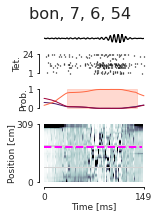

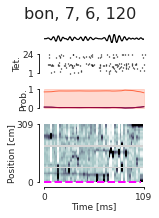

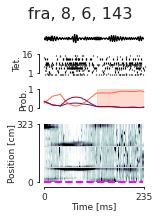

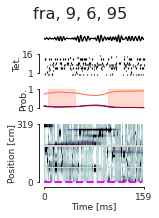

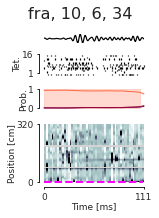

In [7]:
for epoch_key, df in frag.groupby(["Animal ID", "day", "epoch"]):
    print(epoch_key)
    plot_ripple_figure_1D(
        epoch_key,
        df.reset_index().ripple_number.values,
        is_save_figure=False,
        cmap="bone_r",
        make_movie=False,
    )

In [8]:
client.close()